In [11]:
import os
import pandas as pd

from pprint import pprint

import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from pytorch_lightning import LightningModule, Trainer, seed_everything

from transformers import BertForSequenceClassification, BertTokenizer, AdamW

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import re
import emoji
from soynlp.normalizer import repeat_normalize

In [12]:
device = torch.device("cuda:0")

In [13]:
MODEL_NAME= "beomi/kobert"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

OSError: Model name 'beomi/kobert' was not found in tokenizers model name list (bert-base-uncased, bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased, bert-base-multilingual-cased, bert-base-chinese, bert-base-german-cased, bert-large-uncased-whole-word-masking, bert-large-cased-whole-word-masking, bert-large-uncased-whole-word-masking-finetuned-squad, bert-large-cased-whole-word-masking-finetuned-squad, bert-base-cased-finetuned-mrpc, bert-base-german-dbmdz-cased, bert-base-german-dbmdz-uncased, TurkuNLP/bert-base-finnish-cased-v1, TurkuNLP/bert-base-finnish-uncased-v1, wietsedv/bert-base-dutch-cased). We assumed 'beomi/kobert' was a path, a model identifier, or url to a directory containing vocabulary files named ['vocab.txt'] but couldn't find such vocabulary files at this path or url.

In [ ]:
import pandas as pd
data_path ='C:/Users/USER/Desktop/2021_korean_hate_speech_detection/hs_CORAL/dataset/'
koco_train_df = pd.read_csv(data_path+"koco_hate_train.txt", sep="\t")
koco_test_df = pd.read_csv(data_path+"koco_hate_test.txt", sep="\t")
koco_train_df.head(5)

In [ ]:
tokenized_train_sentences = tokenizer(
                            list(koco_train_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

tokenized_test_sentences = tokenizer(
                            list(koco_test_df['comments']),
                            return_tensors="pt",
                            max_length=64,
                            padding=True,
                            truncation=True,
                            add_special_tokens=True)

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    
    def __len__(self):
        return len(self.labels)

In [ ]:
train_label = koco_train_df["hate"].values
test_label =  koco_test_df["hate"].values

train_dataset = MyDataset(tokenized_train_sentences, train_label)
test_dataset = MyDataset(tokenized_test_sentences, test_label)

# 모델 튜닝

In [5]:
from coral_pytorch.layers import CoralLayer
from coral_pytorch.losses import CoralLoss
from coral_pytorch.dataset import levels_from_labelbatch
from coral_pytorch.dataset import proba_to_label
from coral_pytorch.losses import corn_loss
from typing import Optional

In [6]:
from transformers.modeling_outputs import SequenceClassifierOutput

ModuleNotFoundError: No module named 'transformers.modeling_outputs'

In [7]:
from transformers import BertPreTrainedModel, BertModel
import torch.nn as nn
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = 0.2
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels-1)
        
        #self.coral_layer = CoralLayer(config.hidden_size, config.num_labels)
        # Initialize weights and apply final processing

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        #logits = self.coral_layer(pooled_output)
        self.probas1 = torch.sigmoid(logits)
        self.probas = torch.cumprod(self.probas1, dim=1)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
            elif self.config.problem_type == 'CORAL':
                #loss_fct = CoralLoss()
                #levels = levels_from_labelbatch(labels.view(-1) , num_classes=3).to(device)
                #loss = loss_fct(logits, levels)
                loss = corn_loss(logits, labels, self.config.num_labels)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=self.probas,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [8]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [10]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                      num_labels=3,
                                                      problem_type='CORAL')

OSError: Can't load config for 'beomi/kobert'. Make sure that:

- 'beomi/kobert' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'beomi/kobert' is the correct path to a directory containing a config.json file



In [42]:
from kobert import get_pytorch_kobert_model
input_ids = torch.LongTensor([[31, 51, 99], [15, 5, 0]])
input_mask = torch.LongTensor([[1, 1, 1], [1, 1, 0]])
token_type_ids = torch.LongTensor([[0, 0, 1], [0, 1, 0]])
model, vocab = get_pytorch_kobert_model()
sequence_output, pooled_output = model(input_ids, input_mask, token_type_ids)
print(pooled_output.shape)
print(vocab)
print(sequence_output[0])

C:\Users\USER\AppData\Roaming\Python\Python36\site-packages\mxnet\optimizer\optimizer.py:167: UserWarning: WARNING: New optimizer gluonnlp.optimizer.lamb.LAMB is overriding existing optimizer mxnet.optimizer.optimizer.LAMB
  Optimizer.opt_registry[name].__name__))


using cached model. C:\Users\USER\Desktop\2022_master\KoBERT\.cache\kobert_v1.zip


loading configuration file .cache\kobert_from_pretrained\config.json
Model config BertConfig {
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.9.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 8002
}

loading weights file .cache\kobert_from_pretrained\pytorch_model.bin


using cached model. C:\Users\USER\Desktop\2022_master\KoBERT\.cache\kobert_news_wiki_ko_cased-1087f8699e.spiece


All model checkpoint weights were used when initializing BertModel.

All the weights of BertModel were initialized from the model checkpoint at .cache\kobert_from_pretrained.
If your task is similar to the task the model of the checkpoint was trained on, you can already use BertModel for predictions without further training.


AttributeError: 'str' object has no attribute 'shape'

In [43]:
pooled_output

'pooler_output'

In [28]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/', # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size=4,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/logs/',# 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [39]:
from transformers import Trainer
#model.load_state_dict(torch.load('KcELECTRA_output/KcELECTRA_hate_outputs/pytorch_model.bin'))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [40]:
trainer.train()

***** Running training *****
  Num examples = 7896
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19740
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


TypeError: forward() got an unexpected keyword argument 'labels'

In [31]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.2773211002349854,
 'eval_accuracy': 0.33970276008492567,
 'eval_f1': 0.16904384574749076,
 'eval_precision': 0.11323425336164189,
 'eval_recall': 0.3333333333333333,
 'eval_runtime': 0.4584,
 'eval_samples_per_second': 1027.568,
 'eval_steps_per_second': 32.725,
 'epoch': 10.0}

In [32]:
trainer.save_model()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/pytorch_model.bin


In [33]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.34      1.00      0.51       160
           1       0.00      0.00      0.00       189
           2       0.00      0.00      0.00       122

    accuracy                           0.34       471
   macro avg       0.11      0.33      0.17       471
weighted avg       0.12      0.34      0.17       471



C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

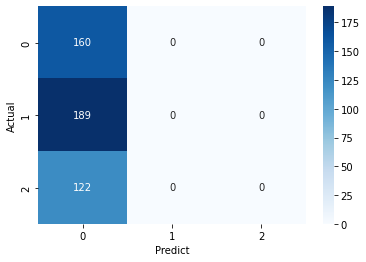

In [34]:
## classification_report
from sklearn.metrics import classification_report
y_test = test_dataset.labels
preds_list = proba_to_label(torch.tensor(predictions.predictions))
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [35]:
from coral_pytorch.dataset import proba_to_label

def compute_mae_and_mse(label, preds_list):

    mae, mse = 0., 0.
    num_examples = len(label)
    targets = torch.tensor(label)
    predicted_labels = torch.tensor(preds_list)
    
    mae += torch.sum(torch.abs(predicted_labels - targets))
    mse += torch.sum((predicted_labels - targets)**2)

    mae = mae / num_examples
    mse = mse / num_examples
    return mae, mse

In [36]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.9193)
tensor(1.4374)


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [37]:
predictions

PredictionOutput(predictions=array([[0.482787  , 0.27311647],
       [0.48278776, 0.27311704],
       [0.48277757, 0.273109  ],
       [0.48279187, 0.27312034],
       [0.48278674, 0.27311626],
       [0.48279047, 0.27311924],
       [0.48279265, 0.2731209 ],
       [0.4827867 , 0.2731162 ],
       [0.48278868, 0.27311778],
       [0.48278302, 0.27311328],
       [0.48277953, 0.2731105 ],
       [0.48278224, 0.27311265],
       [0.4827738 , 0.27310598],
       [0.48278725, 0.27311668],
       [0.4827829 , 0.27311322],
       [0.48278442, 0.27311438],
       [0.4827993 , 0.27312624],
       [0.48279002, 0.27311882],
       [0.48278534, 0.2731152 ],
       [0.4827845 , 0.2731145 ],
       [0.48279348, 0.27312163],
       [0.48277628, 0.27310795],
       [0.48278913, 0.27311817],
       [0.48279548, 0.27312317],
       [0.48278224, 0.27311268],
       [0.48278296, 0.27311322],
       [0.4827816 , 0.27311212],
       [0.48278803, 0.27311724],
       [0.48278436, 0.27311432],
       [0.4827

# iw and threshold

In [12]:
from scipy import special
import pandas as pd

def custom_proba_to_label(probas, first_threshold, second_threshold):
    predict_levels = pd.DataFrame(probas)
    class_O = predict_levels[0].apply(lambda x: x > first_threshold)
    class_H = predict_levels[1].apply(lambda x: x > second_threshold)
    labels_v3 = pd.concat([class_O, class_H], axis=1)
    labels_v3 = labels_v3.sum(axis=1)
    return labels_v3

In [13]:
from transformers import BertPreTrainedModel, BertModel
import torch.nn as nn
class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.bert = BertModel(config)
        classifier_dropout = 0.2
        self.dropout = nn.Dropout(classifier_dropout)
        #self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        
        self.coral_layer = CoralLayer(config.hidden_size, config.num_labels)
        # Initialize weights and apply final processing

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ):
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        #logits = self.classifier(pooled_output)
        logits = self.coral_layer(pooled_output)
        probas = torch.sigmoid(logits)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
            elif self.config.problem_type == 'CORAL':
                iw = torch.tensor([0.7, 0.3]).to(device)
                loss_fct = CoralLoss()
                levels = levels_from_labelbatch(labels.view(-1) , num_classes=3).to(device)
                loss = loss_fct(logits, levels, importance_weights=iw)
        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=probas,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [14]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, 
                                                      num_labels=3,
                                                      problem_type='CORAL')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kobert and are newly initialized: ['coral_layer.coral_weights.weight', 'coral_layer.coral_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/', # 학습결과 저장경로
    num_train_epochs=10,                # 학습 epoch 설정
    per_device_train_batch_size=4,      # train batch_size 설정
    per_device_eval_batch_size=32,      # test batch_size 설정
    logging_dir='C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/logs/',# 학습log 저장경로
    logging_steps=500,                  # 학습log 기록 단위
    save_total_limit=2,                 # 학습결과 저장 최대갯수 
)

In [16]:
from transformers import Trainer
#model.load_state_dict(torch.load('KcELECTRA_output/KcELECTRA_hate_outputs/pytorch_model.bin'))
trainer = Trainer(
    model=model,                         # 학습하고자하는 🤗 Transformers model
    args=training_args,                  # 위에서 정의한 Training Arguments
    train_dataset=train_dataset,         # 학습 데이터셋
    eval_dataset=test_dataset,           # 평가 데이터셋
    compute_metrics=compute_metrics,     # 평가지표
)

In [17]:
trainer.train()

***** Running training *****
  Num examples = 7896
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 19740
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss
500,0.678200
1000,0.674100
1500,0.668500
2000,0.670300
2500,0.666700
3000,0.667000
3500,0.667200
4000,0.662200
4500,0.666600
5000,0.661800


Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-500\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoBERT(CORAL)_outputs\output\checkpoint-1000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-1000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/ou

Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-5500\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoBERT(CORAL)_outputs\output\checkpoint-4500] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-6000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-6000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-6000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoB

C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-11000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-11000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-11000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoBERT(CORAL)_outputs\output\checkpoint-10000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or s

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-16000
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-16000\config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-16000\pytorch_model.bin
Deleting older checkpoint [C:\Users\USER\Desktop\2022_master\KoBERT\KoBERT(CORAL)_outputs\output\checkpoint-15000] due to args.save_total_limit
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/checkpoint-16500
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_ou

TrainOutput(global_step=19740, training_loss=0.6596052307005228, metrics={'train_runtime': 1284.8605, 'train_samples_per_second': 61.454, 'train_steps_per_second': 15.364, 'total_flos': 2596882830151680.0, 'train_loss': 0.6596052307005228, 'epoch': 10.0})

In [18]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6515346169471741,
 'eval_accuracy': 0.33970276008492567,
 'eval_f1': 0.16904384574749076,
 'eval_precision': 0.11323425336164189,
 'eval_recall': 0.3333333333333333,
 'eval_runtime': 0.4493,
 'eval_samples_per_second': 1048.238,
 'eval_steps_per_second': 33.383,
 'epoch': 10.0}

In [19]:
trainer.save_model()

Saving model checkpoint to C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/
Configuration saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/config.json
Model weights saved in C:/Users/USER/Desktop/2022_master/KoBERT/KoBERT(CORAL)_outputs/output/pytorch_model.bin


In [20]:
predictions = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 471
  Batch size = 32
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
predicts_threshold = custom_proba_to_label(predictions.predictions.tolist(), 0.3, 0.7)

C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\USER\anaconda3\envs\badText10-KcBERT\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.40      1.00      0.57       189
           2       0.00      0.00      0.00       122

    accuracy                           0.40       471
   macro avg       0.13      0.33      0.19       471
weighted avg       0.16      0.40      0.23       471



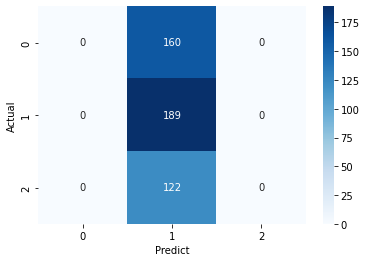

In [22]:
## classification_report
y_test = predictions.label_ids
preds_list = predicts_threshold
from sklearn.metrics import classification_report
clf_report = classification_report(y_test, preds_list)
print(clf_report)

# 오차행렬 생성
from sklearn.metrics import classification_report, confusion_matrix
cf_matrix = confusion_matrix(y_test, preds_list)

# 오차행렬 시각화
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [23]:
predictions

PredictionOutput(predictions=array([[0.5160465 , 0.30537662],
       [0.51605564, 0.30538434],
       [0.5160529 , 0.305382  ],
       [0.5160514 , 0.30538073],
       [0.516052  , 0.30538124],
       [0.5160486 , 0.30537835],
       [0.516046  , 0.30537608],
       [0.51605844, 0.30538666],
       [0.5160486 , 0.30537835],
       [0.5160571 , 0.30538553],
       [0.51604813, 0.30537793],
       [0.5160456 , 0.30537575],
       [0.51604944, 0.30537906],
       [0.51605606, 0.30538464],
       [0.5160587 , 0.30538693],
       [0.5160503 , 0.30537975],
       [0.51605165, 0.3053809 ],
       [0.5160445 , 0.30537486],
       [0.51605296, 0.30538204],
       [0.51605326, 0.3053823 ],
       [0.51605195, 0.3053812 ],
       [0.51604915, 0.3053788 ],
       [0.51605237, 0.3053815 ],
       [0.51605475, 0.3053836 ],
       [0.5160505 , 0.30538   ],
       [0.5160615 , 0.30538926],
       [0.51605344, 0.30538246],
       [0.5160576 , 0.30538598],
       [0.5160569 , 0.30538535],
       [0.5160

In [24]:
mae, mse = compute_mae_and_mse(y_test, preds_list)
print(mae)
print(mse)

tensor(0.5987)
tensor(0.5987)
